# Elastic Rod Model

In [1]:
from IPython.display import display, Markdown
import random
def latexify(x):
    out = '$' + x + '$'
    return out

def lprint(x):
    display(Markdown(latexify(latex(x))))
    
%run -i 'implicit.py'

import matplotlib.pyplot as plt

In this notebook a discretisation of the elastic rod bifurcation problem will be investigated

here we consider rods connected by elastic joints that resist angular perturbation, with a forcing action attempting to squash the rod

In [2]:
var('x')

lprint(arcsin(x))

$ \arcsin\left(x\right) $

In [3]:
def get_funcs(n):
    # returns a set of equations to solve

    var_dict = {}
    
    var_dict['g'] = var('g')
    
    for i in range(0,n):
        # theta is the angle from the horizontal the ith line branches from
        var_dict['theta{}'.format(i)] = var('theta{}'.format(i), latex_name = r'\theta_{}'.format(i))
        
    var_dict['theta{}'.format(n)] = 0 # will update
        
    # compute the last theta, since must have the endpoints both zero on the vertical
    for i in range(0,n):
        var_dict['theta{}'.format(n)] = var_dict['theta{}'.format(n)] - sin(var_dict['theta{}'.format(i)])
        
    var_dict['theta{}'.format(n)] = arcsin(var_dict['theta{}'.format(n)])
    
    var_dict['l'] = var('l', latex_name=r'\lambda') # compressive force
   
    
    funcs = []
    energy = 0
    height = 0
    for j in range(1,n+1):
        # iterate through each spring in the rod
        e_spring = (var_dict['theta{}'.format(j-1)] - var_dict['theta{}'.format(j)])^2 
        height = height + sin(var_dict['theta{}'.format(j - 1)]) # a bit of trigonometry
        # since pi - (pi - theta0 - theta1) e.g
        energy = energy + e_spring + var_dict['g']*height # each spring has unit mass 
        
    hoz = 0
    for i in range(0,n+1):
        # total horizontal extension
        hoz = hoz + cos(var_dict['theta{}'.format(i)])
        
           
    # take away the work done by the force
    energy = energy - var_dict['l']*(n + 1 - hoz)
            
    # solutions will be local minima of the energy equation
    for j in range(0,n):
        #don't care about the last angle
        funcs.append(energy.diff(var_dict['theta{}'.format(j)]))
        
    del var_dict['theta{}'.format(n)] # this was just a latent variable
        
    return funcs, var_dict
    

In [4]:
funcs, var_dict = get_funcs(2)

In [5]:
var_dict

{'g': g, 'theta0': theta0, 'theta1': theta1, 'l': l}

In [6]:
lprint(funcs)

$ \left[-{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_0}\right)\right)} {\lambda} + 2 \, g \cos\left({\theta_0}\right) + \frac{2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} \cos\left({\theta_0}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 2 \, {\theta_0} - 2 \, {\theta_1}, -{\left(\frac{{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)} \cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + \sin\left({\theta_1}\right)\right)} {\lambda} + 2 \, {\left({\theta_1} - \arcsin\left(-\sin\left({\theta_0}\right) - \sin\left({\theta_1}\right)\right)\right)} {\left(\frac{\cos\left({\theta_1}\right)}{\sqrt{-{\left(\sin\left({\theta_0}\right) + \sin\left({\theta_1}\right)\right)}^{2} + 1}} + 1\right)} + g \cos\left({\theta_1}\right) - 2 \, {\theta_0} + 2 \, {\theta_1}\right] $

In [7]:
funcs[1]

-((sin(theta0) + sin(theta1))*cos(theta1)/sqrt(-(sin(theta0) + sin(theta1))^2 + 1) + sin(theta1))*l + 2*(theta1 - arcsin(-sin(theta0) - sin(theta1)))*(cos(theta1)/sqrt(-(sin(theta0) + sin(theta1))^2 + 1) + 1) + g*cos(theta1) - 2*theta0 + 2*theta1

In [8]:
lprint(funcs[1](g,l,0,0)) # no trivial plane of solutions

$ g $

In [9]:
lprint(funcs[1](0,l,0,0)) # still trivial solutons if we treat g as an x variable

$ 0 $

lets ignore $g$ for the time being, we will just treat it as another variable in the implicit function theorem, since that only insists on requirements on the $X$ variables

In [10]:
old_var = var_dict
var_dict = {key : var_dict[key] for key in var_dict.keys() if var_dict[key] != 0}
var_dict = {key : var_dict[key] for key in var_dict.keys() if key != 'l' and key != 'g'}

J = jacobian(funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(J)

$ \left(\begin{array}{rr}
-2 \, {\lambda} + 4 & -{\lambda} + 2 \\
-{\lambda} + 2 & -2 \, {\lambda} + 10
\end{array}\right) $

In [11]:
lprint(det(matrix(J))) # potential bifurcation point

$ -{\left({\lambda} - 2\right)}^{2} + 4 \, {\left({\lambda} - 2\right)} {\left({\lambda} - 5\right)} $

In [12]:
lprint(solve(det(matrix(J)), l))

$ \left[{\lambda} = 2, {\lambda} = 6\right] $

We see there are four different force strenghts that seem to produce bifurcations

In [13]:
bifs = list(solve(det(matrix(J)), l))
[float(bif.rhs()) for bif in bifs]

[2.0, 6.0]

In [14]:
bif_tuples = []

for i in tqdm.tqdm([0,1]):
    bif_funcs = [func(l = bifs[i].rhs()) for func in funcs]
    J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x : float(x))
    # do floating point since we are only looking right now
    K = [epair for epair in J.eigenvectors_right() if abs(epair[0]) < 10e-15][0][1][0] # since float now a solution is found as a highly degenerate eigenvector
    bif_tuples.append((bifs[i].rhs(), K))

100%|██████████| 2/2 [00:00<00:00,  5.50it/s]


In [15]:
def angles_to_coords(angles):
    # produces the coordinates of a line with angles inputted
    coords = []
    coords.append((0,0))
    
    sin_sum = sum([sin(angle) for angle in angles])
    temp_angles = list(angles)
    temp_angles.append(arcsin(-sin_sum))
    
    for angle in temp_angles:
        now = coords[-1]
        new_x = now[0] + cos(angle)
        new_y = now[1] + sin(angle)
        coords.append((new_x, new_y))
        
        
    return coords

In [16]:
def plot_angles(angles, save = False, save_name = 'plot1', folder = 'plots', show = True, title=None):

    plt.axes
    plt.xlim([-1,5])
    plt.ylim([-2,2])

    points = angles_to_coords(tuple(angles))
    for i in range(int(0), int(len(points) - 1)):
        line = plt.Line2D((points[i][0], points[i+1][0]), (points[i][1], points[i+1][1]), lw=2.5)
        plt.gca().add_line(line)
        plt.gca().set_aspect('equal')
        if title is not None:
            plt.title(title)
    if save is True:
        plt.savefig('{}/{}.png'.format(folder, save_name))
        
    if show is True:
        plt.show()
        
    plt.cla()
    return   

2


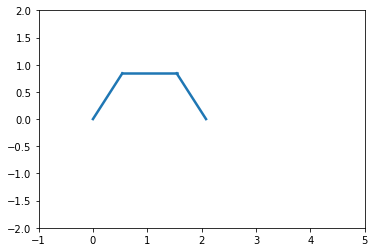

6


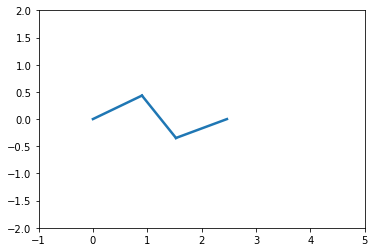

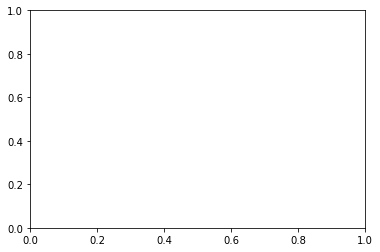

In [17]:
count = 1
for bif_tuple in bif_tuples:
    print(bif_tuple[0])
    plot_angles(bif_tuple[1], save = True, save_name = 'plot{}'.format(count))
    count+=1

These are the bifurcations in absence of gravity

In [18]:
#bif_funcs = [func(l = 2/((32*sqrt(2)) + 36)) for func in funcs] #
#bif_funcs = [func(l = (sqrt(2)*(9/4))/((225*sqrt(2))/2 + 108)) for func in funcs] #
bif_funcs = [func(l = 6) for func in funcs]
#var_dict['l'] = old_var['l']
J = jacobian(bif_funcs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()})

lprint(J)

$ \left(\begin{array}{rr}
-8 & -4 \\
-4 & -2
\end{array}\right) $

### Orthogonalising the kernel

In [19]:
K = J.right_kernel().basis()
K = K[0].apply_map(lambda x: x.full_simplify())
lprint(K)

$ \left(1,\,-2\right) $

In [20]:
Kperp = matrix(K).right_kernel().basis()
lprint(Kperp)

$ \left[\left(1,\,\frac{1}{2}\right)\right] $

In [21]:
A = matrix([K]+Kperp).transpose().apply_map(lambda x: x.full_simplify())
lprint(A)

$ \left(\begin{array}{rr}
1 & 1 \\
-2 & \frac{1}{2}
\end{array}\right) $

In [22]:
key_list = [str(var) for var in var_dict.values()]
value_list = list(A*vector(var_dict.values()))
mutate_dict = dict(zip(key_list, value_list))

In [23]:
mutate_dict

{'theta0': theta0 + theta1, 'theta1': -2*theta0 + 1/2*theta1}

In [24]:
Afuncs = [func(**mutate_dict) for func in bif_funcs]

In [25]:
#lprint(Afuncs) 

In [26]:
Ja = jacobian(Afuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())
lprint(Ja)

$ \left(\begin{array}{rr}
0 & -10 \\
0 & -5
\end{array}\right) $

In [27]:
Ka = Ja(l=0).right_kernel().basis()
lprint(Ka)

$ \left[\left(1,\,0\right)\right] $

### Orthogonalising the image

In [28]:
I = Ja.image().basis()
I = [Ja*vec for vec in I]
print(len(I))

1


In [29]:
Iperp = matrix(I).right_kernel().basis()
Iperp = Iperp[0].apply_map(lambda x: x.full_simplify())
lprint(Iperp)

$ \left(1,\,-2\right) $

In [30]:
B = matrix(I + [Iperp]).inverse().apply_map(lambda x: x.full_simplify())
lprint(B)

$ \left(\begin{array}{rr}
-\frac{2}{25} & \frac{1}{5} \\
-\frac{1}{25} & -\frac{2}{5}
\end{array}\right) $

In [31]:
tfuncs = vector(Afuncs)*B

In [32]:
#lprint(tfuncs)

In [33]:
Jt = jacobian(tfuncs,tuple(var_dict.values()))(**{var : 0 for var in var_dict.keys()}).apply_map(lambda x: x.full_simplify())

In [34]:
var_dict.values()

dict_values([theta0, theta1])

In [35]:
lprint(Jt)

$ \left(\begin{array}{rr}
0 & 1 \\
0 & 0
\end{array}\right) $

In [36]:
It = Jt.image().basis()
It = [Jt*vec for vec in It]
lprint(It)

$ \left[\left(1,\,0\right)\right] $

## Adding lambda back in

In [37]:
tfuncs = vector([func(**mutate_dict)(l = l + 6) for func in funcs])*B # now lambda is not fixed at the bifurcation point
# ***IF SOMETHING IS BROKEN CHECK RIGHT LAMBDA HERE***
# but we do shift so that l=0 is the new bifurcation
var_dict['l'] = l
var_dict['g'] = g

In [38]:
var_dict_old = var_dict
var_dict_old

{'theta0': theta0, 'theta1': theta1, 'l': l, 'g': g}

In [39]:
var_dict.values()

dict_values([theta0, theta1, l, g])

In [40]:
#lprint(tfuncs[1])

## Running the implicit function theorem

In [41]:
len(tfuncs)

2

In [42]:
position = {key : 0 for key in var_dict_old.keys()}
position

{'theta0': 0, 'theta1': 0, 'l': 0, 'g': 0}

In [43]:
#code_funcs = [tfuncs[index].function(*list(var_dict_old.values())) for index in [0,1,2,3,4,5,6]] # careful with computer science indexing from zero
code_funcs = [tfuncs[index] for index in [0]] # the last function has degenerate first derivative always
position = {key : 0 for key in var_dict_old.keys()}
# var_dict already loaded
var_dict = {'y1' : theta1, 'x1' : g, 'x2' : l, 'x3' : theta0}
x_var_keys = ['g', 'l', 'theta0'] # the variables in the kernel
x_dim = 3
y_dim = 1 # invertible part

In [44]:
var_dict.keys()

dict_keys(['y1', 'x1', 'x2', 'x3'])

In [45]:
t_dict = TensorDict(code_funcs, position, var_dict, x_dim, y_dim)

computing Taylor approximaton to 3 order for speedup


In [46]:
out = get_hkx_polynomial(code_funcs, 5, x_dim, y_dim, var_dict, x_var_keys, t_dict, position)

100%|██████████| 1/1 [00:00<00:00,  5.96it/s]


[1]


100%|██████████| 4/4 [00:01<00:00,  3.72it/s]


[1]


100%|██████████| 14/14 [00:06<00:00,  2.07it/s]


[1]


  0%|          | 0/51 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 51/51 [00:42<00:00,  1.21it/s]


[1]


  0%|          | 0/202 [00:00<?, ?it/s]

updating Taylor series


100%|██████████| 202/202 [04:36<00:00,  1.37s/it]


[1]


In [47]:
lprint(out[0].full_simplify()) # our h function # its too big

$ \frac{887927}{750000000} \, g^{5} + \frac{38416}{1953125} \, g {\lambda}^{4} + \frac{279601}{75000} \, g {\theta_0}^{4} - \frac{7669}{2500} \, {\theta_0}^{5} - \frac{2744}{78125} \, g {\lambda}^{3} - \frac{1}{31250} \, {\left(2248 \, g^{2} + 20333 \, {\lambda}^{2} - 24025 \, {\lambda} + 23750\right)} {\theta_0}^{3} - \frac{277}{25000} \, g^{3} - \frac{7}{234375} \, {\left(499 \, g^{3} - 2100 \, g\right)} {\lambda}^{2} - \frac{1}{1250000} \, {\left(145057 \, g^{3} - 853806 \, g {\lambda}^{2} + 989200 \, g {\lambda} - 1015000 \, g\right)} {\theta_0}^{2} + \frac{1}{937500} \, {\left(14963 \, g^{3} - 105000 \, g\right)} {\lambda} + \frac{1}{4687500} \, {\left(5285 \, g^{4} - 98784 \, {\lambda}^{4} - 360 \, {\left(163 \, g^{2} + 875\right)} {\lambda}^{2} + 176400 \, {\lambda}^{3} + 236250 \, g^{2} - 900 \, {\left(123 \, g^{2} - 625\right)} {\lambda}\right)} {\theta_0} + \frac{1}{5} \, g $

## Testing the implicit function theorem

In [48]:
subbed = [func(theta1 = out[0]) for func in tqdm.tqdm(tfuncs)]

100%|██████████| 2/2 [00:00<00:00, 109.60it/s]


In [49]:
[float(func(g = 2, l = 0.1, theta0 = 1)) for func in tqdm.tqdm(subbed)]

100%|██████████| 2/2 [00:00<00:00, 54.76it/s]


[-1.2305474541461519, 7.134246421667008]

the last function remains to be solved

### Looking for more solutions

Now substitute this into the equation that had degenerate image

In [50]:
tf_taylor = tfuncs[1].taylor(*[(key,value) for key,value in position.items()],5) # taylor expand the function with degenerate image
lprint(tf_taylor.polynomial(SR)) # all three variables are present

$ \left(-\frac{1}{4}\right) g \theta_{0}^{4} + \left(-\frac{213}{50}\right) \theta_{0}^{5} + \frac{1}{3} g \theta_{0}^{3} \theta_{1} + \frac{313}{40} \theta_{0}^{4} \theta_{1} + \frac{81}{40} \theta_{0}^{3} \theta_{1}^{2} + \frac{1}{12} g \theta_{0} \theta_{1}^{3} + \left(-\frac{553}{80}\right) \theta_{0}^{2} \theta_{1}^{3} + \frac{1}{64} g \theta_{1}^{4} + \left(-\frac{161}{320}\right) \theta_{0} \theta_{1}^{4} + \frac{68}{75} \theta_{1}^{5} + \frac{7}{5} l \theta_{0}^{3} + \left(-\frac{9}{5}\right) l \theta_{0}^{2} \theta_{1} + \frac{13}{40} l \theta_{0} \theta_{1}^{2} + \frac{2}{5} l \theta_{1}^{3} + \frac{3}{5} g \theta_{0}^{2} + \frac{18}{5} \theta_{0}^{3} + \left(-\frac{4}{5}\right) g \theta_{0} \theta_{1} + \left(-\frac{57}{10}\right) \theta_{0}^{2} \theta_{1} + \left(-\frac{3}{20}\right) g \theta_{1}^{2} + \frac{81}{20} \theta_{0} \theta_{1}^{2} + \frac{17}{20} \theta_{1}^{3} + \left(-\frac{6}{5}\right) l \theta_{0} + \frac{3}{10} l \theta_{1} $

In [51]:
tf_sub = tf_taylor(theta1 = out[0]) # substitute in h

In [52]:
local = symbolic_expression(sum([a[0]*a[1] for a in tf_sub.polynomial(SR) if a[1].degree() <= 5]))
#local = tf_sub.polynomial(SR).truncate(4)
lprint(local) # will see that we can take out a factor of theta0 = xi0

$ -\frac{11267}{75000000} \, g^{5} + \frac{20507}{3125000} \, g^{3} {\lambda}^{2} - \frac{4116}{390625} \, g {\lambda}^{4} - \frac{106607}{15000000} \, g^{4} {\theta_0} + \frac{11539}{156250} \, g^{2} {\lambda}^{2} {\theta_0} + \frac{882}{78125} \, {\lambda}^{4} {\theta_0} + \frac{10411}{125000} \, g^{3} {\theta_0}^{2} - \frac{33531}{62500} \, g {\lambda}^{2} {\theta_0}^{2} + \frac{37073}{75000} \, g^{2} {\theta_0}^{3} + \frac{57}{125} \, {\lambda}^{2} {\theta_0}^{3} - \frac{19683}{5000} \, g {\theta_0}^{4} + \frac{9}{125} \, {\theta_0}^{5} - \frac{1207}{250000} \, g^{3} {\lambda} + \frac{294}{15625} \, g {\lambda}^{3} - \frac{1467}{25000} \, g^{2} {\lambda} {\theta_0} - \frac{63}{3125} \, {\lambda}^{3} {\theta_0} + \frac{1551}{2500} \, g {\lambda} {\theta_0}^{2} + \frac{61}{125} \, {\lambda} {\theta_0}^{3} + \frac{1}{1250} \, g^{3} - \frac{21}{625} \, g {\lambda}^{2} + \frac{1}{500} \, g^{2} {\theta_0} + \frac{9}{250} \, {\lambda}^{2} {\theta_0} - \frac{27}{50} \, g {\theta_0}^{2} + \frac{18}{5} \, {\theta_0}^{3} + \frac{3}{50} \, g {\lambda} - \frac{6}{5} \, {\lambda} {\theta_0} $

In [69]:
latex(local)

-\frac{11267}{75000000} \, g^{5} + \frac{20507}{3125000} \, g^{3} {\lambda}^{2} - \frac{4116}{390625} \, g {\lambda}^{4} - \frac{106607}{15000000} \, g^{4} {\theta_0} + \frac{11539}{156250} \, g^{2} {\lambda}^{2} {\theta_0} + \frac{882}{78125} \, {\lambda}^{4} {\theta_0} + \frac{10411}{125000} \, g^{3} {\theta_0}^{2} - \frac{33531}{62500} \, g {\lambda}^{2} {\theta_0}^{2} + \frac{37073}{75000} \, g^{2} {\theta_0}^{3} + \frac{57}{125} \, {\lambda}^{2} {\theta_0}^{3} - \frac{19683}{5000} \, g {\theta_0}^{4} + \frac{9}{125} \, {\theta_0}^{5} - \frac{1207}{250000} \, g^{3} {\lambda} + \frac{294}{15625} \, g {\lambda}^{3} - \frac{1467}{25000} \, g^{2} {\lambda} {\theta_0} - \frac{63}{3125} \, {\lambda}^{3} {\theta_0} + \frac{1551}{2500} \, g {\lambda} {\theta_0}^{2} + \frac{61}{125} \, {\lambda} {\theta_0}^{3} + \frac{1}{1250} \, g^{3} - \frac{21}{625} \, g {\lambda}^{2} + \frac{1}{500} \, g^{2} {\theta_0} + \frac{9}{250} \, {\lambda}^{2} {\theta_0} - \frac{27}{50} \, g {\theta_0}^{2} + \fr

We see that this will have solutions, therefore the point $\lambda$ is indeed a bifurcation point, and if we fix the $p10x$ variable at zero then $\lambda$ will span the local solutions.

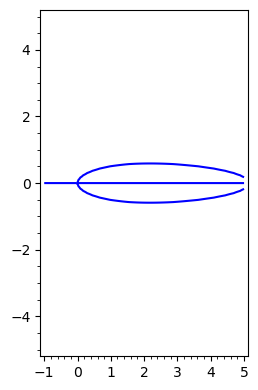

In [53]:
implicit_plot(local(g = 0), (-1,5), (-5,5))

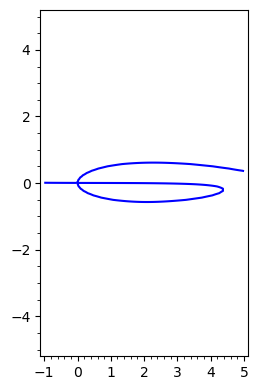

In [54]:
implicit_plot(local(g = 0.1), (-1,5), (-5,5))

In [55]:
implicit_plot(local(g = 2), (-1,5), (-5,5)).save('imperf.png')

In [67]:
n = 100

for i in tqdm.tqdm(range(0,n)):
    implicit_plot(local(g = i/n), (-1,5), (-5,5), axes_labels=['$\\lambda$', '$\\theta_{0}$'], title = 'g = 0.{}'.format(f'{i:02d}')).save('plots/multi_imperf6/plot{}.png'.format({i}))


100%|██████████| 100/100 [02:03<00:00,  1.23s/it]
